<a href="https://colab.research.google.com/github/JonasVerbickas/GYMTABLER/blob/master/NLP_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
import os
import nltk
import re
import string
import unicodedata
import time
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
from collections import UserDict
from tqdm import tqdm

I'm not sure how you will access the corpus on your side.
Personally, I've uploaded it to my Google drive.

In [157]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [158]:
porter = nltk.PorterStemmer()

# Download additional NLTK resources
These are required for tokenization and stop-word removal

In [159]:
nltk.download('punkt')
nltk.download('stopwords')
# I convert it into a set, because it results in faster `in` look-ups
STOP_WORDS = nltk.corpus.stopwords.words('english')
# convert to set() for faster `in` checks
STOP_WORDS = set(STOP_WORDS)
STOP_WORDS

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

# Implementation


## Initialize helper classes
I could've coded everything using tuples/lists instead of these helper classes.

However, I feel like these make the code more verbose and remove ambiguity that comes from giving positions in a tuple meaning.

In [160]:
class StringWithDocId:
  """
  Used in InvertedIndex.read_data method to create a list of document contents with doc_ids 
  """ 
  def __init__(self, string, doc_id):
    self.string = string
    self.doc_id = doc_id
  
  def __str__(self):
    return f"{self.string}: {self.doc_id}"

  def __repr__(self):
    return f"{self.string}: {self.doc_id}"

In [161]:
class StringWithDocIdAndPosition(StringWithDocId):
  """
  Stores positions as well.
  Used to create & sort list of positional terms.
  
  """
  def __init__(self, string, doc_id, position):
    super().__init__(string, doc_id)
    self.position = position
  
  def __lt__(token_with_doc_A, token_with_doc_B):
    if token_with_doc_A.string != token_with_doc_B.string:
      return token_with_doc_A.string < token_with_doc_B.string
    elif token_with_doc_A.doc_id != token_with_doc_B.doc_id:
      return token_with_doc_A.doc_id < token_with_doc_B.doc_id
    else:
      return token_with_doc_A.position < token_with_doc_B.position

In [162]:
class Posting(UserDict):
  """
  This stores the positional information for each term in the postional inverted index.
  Some methods have been overriden to its objects behave like dictionary.
  Keys are all of documents where this term appears;
  Values store the positions, where in that document term appears
  {docID: [pos1, pos2, ...]}.
  """
  def __init__(self):
    super().__init__()
    self.posting_dic = {}
    self.total_occurances = 0
  
  def __contains__(self, doc_id):
    return doc_id in self.posting_dic
  
  def __iter__(self):
      return iter(self.posting_dic.items())

  def __getitem__(self, doc_id):
      return self.posting_dic[doc_id]
    
  def get(self, k, default=None):
    return self[k]
  
  def __len__(self):
      return len(self.posting_dic)

  def add(self, doc_id, position):
    if doc_id in self.posting_dic:
      self.posting_dic[doc_id].append(position)
    else:
      self.posting_dic[doc_id] = [position]
    self.total_occurances += 1
  
  def __str__(self):
    return f"{self.total_occurances} total occurances: {[f'{len(positions)} in {doc_id}: {positions}' for doc_id, positions in self.posting_dic.items()]}"
  
  def __repr__(self):
    return str(self)

In [163]:
def wikipediaPreprocessing(text):
  text = unicodedata.normalize('NFKC', text)
  text = text.replace('[edit]', '')
  text = re.sub(r'\[\d+\]', '', text)
  text = re.sub(r'Contents\s+1\s+Plot.+Plot', '', text) 
  # text = re.sub(r'^.+From Wikipedia, the free encyclopedia.+List of episodes', '', text)
  text = text.replace('From Wikipedia, the free encyclopedia', '')
  return text

## Spell correction!!
From P. Norvig's website: https://norvig.com/spell-correct.html.

In [164]:
class SpellCorrect:

  def __init__(self, posting_dict):
    self.total_num_of_words = 0
    self.word_freq_dic = {} 
    for key, val in posting_dict.items():
      self.total_num_of_words += val.total_occurances
      # I don't store positions here, because in case of spell check only frequencies are needed
      self.word_freq_dic[key] = self.total_num_of_words

  def _P(self, word): 
      "Probability of `word`."
      if word in self.word_freq_dic:
        return self.word_freq_dic[word] / self.total_num_of_words
      # If a word doesn't exist within the index
      # It's probality is 0 - this is a way to get rid of words that are not real
      else:
        return 0

  def correction(self, word): 
      "Most probable spelling correction for word."
      most_probable_correction = max(self._candidates(word), key=self._P)
      # if no correction is possible just return None
      if self._P(most_probable_correction) == 0:
        return None
      else:
        return most_probable_correction

  def _candidates(self, word): 
      "Generate possible spelling corrections for word."
      return (self._known([word]) or self._known(self._edits1(word)) or self._known(self._edits2(word)) or [word])

  def _known(self, words): 
      "The subset of `words` that appear in the dictionary of WORDS."
      return set(w for w in words if w in self.word_freq_dic.keys())

  def _edits1(self, word):
      "All edits that are one edit away from `word`."
      letters    = 'abcdefghijklmnopqrstuvwxyz'
      splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
      deletes    = [L + R[1:]               for L, R in splits if R]
      transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
      replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
      inserts    = [L + c + R               for L, R in splits for c in letters]
      return set(deletes + transposes + replaces + inserts)

  def _edits2(self, word): 
      "All edits that are two edits away from `word`."
      return (e2 for e1 in self._edits1(word) for e2 in self._edits1(e1))

## The Inverted Index (THE MOST IMPORTANT BIT)

In [165]:
class InvertedIndex:
    """
    Construct Inverted Index
    """
    def __init__(self):
        self.inverted_index = {}
        # this is a set because there are some duplicates in the CSV files
        self.csv_terms = {} 
        self.ep_titles = {}

    def _appendCSV(self, path):
      """
      Used to fill up csv_terms that are later used to index multi-word terms within the corpus
      1)opens a csv in the given path
      2)processes each term, so that it matches the tokenized corpus
      3)and appends to csv_terms set"""
      df = pd.read_csv(path)
      set_of_csv_entries = df['name']
      for term in set_of_csv_entries:
        processed_tokens = self.processListOfTokens(self.process_document(term))
        # anything of size 1, isn't a multi-word term - don't waste space storing it
        if len(processed_tokens) > 1:
          if len(processed_tokens) not in self.csv_terms:
            self.csv_terms[len(processed_tokens)] = set()
          self.csv_terms[len(processed_tokens)].add(" ".join(processed_tokens))
    
    def read_data(self, path: str) -> list:
        """
        Read files from a directory and then append the data of each file into a list.
        """
        output = []
        for file in os.listdir(path):
          filename_with_path = os.path.join(path, file)
          if (file[-3:]).lower() == 'txt':
            with open(filename_with_path, 'r') as f:
              text = f.read()
              output.append(StringWithDocId(text, file))
              title_of_ep = text.strip().split('\n')[0]
              processed_title_of_ep = self.processListOfTokens(self.process_document(title_of_ep))
              if len(processed_title_of_ep) not in self.ep_titles:
                self.ep_titles[len(processed_title_of_ep)] = set()
              self.ep_titles[len(processed_title_of_ep)].add(" ".join(processed_title_of_ep)) 
          elif (file[-3:]).lower() == 'csv':
            self._appendCSV(filename_with_path)
          else:
            print(filename_with_path, "will be skipped")
        print("First 10 entries of csv_terms:", self.csv_terms)
        print(len(output))
        return output
      
    def processListOfTokens(self, tokenized: list) -> list:
      """
      This removes stop-words, punctuation and stems words.
      This has been made a separate function, because it's needed to process output read_data
      """
      output = []
      for token in tokenized:
        # stop-words only contain lower case versions of words
        # therefore tokens must be lowercased in order to match them
        # casefold() is a more aggresive version of lower()
        # https://docs.python.org/3/library/stdtypes.html#str.casefold
        token = token.casefold()
        # 2. ignore stop-words
        if token in STOP_WORDS:
          continue
        # ignore tokens that don't have words/numbers in them i.e. punctuation only
        if not re.search('\w', token):
          continue
        # delete hyphens
        token = token.replace('-', '')
        # apply stemming
        stemmed = porter.stem(token)
        output.append(stemmed)
      return output

    def process_document(self, document: str) -> list:
        """
        pre-process a document and return a list of its terms
        str->list"""
        # 1. Wikipedia hyperlinks should be removed
        text = wikipediaPreprocessing(document)
        tokenized  = nltk.tokenize.word_tokenize(text)
        # remove stop-words & apply stemming
        filtered_tokens = self.processListOfTokens(tokenized)
        # find title of ep  
        # title_of_ep = text.strip().split('\n')[0]
        # processed_title_of_ep = self.processListOfTokens(nltk.tokenize.word_tokenize(title_of_ep))
        # filtered_tokens.insert(0, " ".join(processed_title_of_ep))     
        return filtered_tokens
    
    def _findMultiWordTerms(self, processed_substring):
        """
        This method tries to find all known multi-token subsections; starting from index [0]
        """        
        csv_subseqs = self._searchForMultiTokenSubsequences(processed_substring[:max(self.csv_terms.keys())], self.csv_terms)
        title_subseqs = self._searchForMultiTokenSubsequences(processed_substring[:max(self.ep_titles.keys())], self.ep_titles)
        return csv_subseqs.union(title_subseqs)
    
    def _searchForMultiTokenSubsequences(self, list_of_processed_tokens, dict_of_subseq_to_look_for):
      matching_subseqs = set()
      # smallest multi-token term is 2, therefore I start looping from it 

      for i in [i for i in range(2, len(list_of_processed_tokens)) if i in dict_of_subseq_to_look_for.keys()]:
        i_joined_tokens = " ".join(list_of_processed_tokens[:i])
        if i_joined_tokens in dict_of_subseq_to_look_for[i]:
          matching_subseqs.add(i_joined_tokens)
      return matching_subseqs

    def index_corpus(self, documents: list) -> None:
        """
        index given documents
        list->None"""
        starting_time = time.perf_counter()
        token_list = []

        # 1. Generate token sequence
        for doc in documents:
          curr_doc_id = doc.doc_id
          tokenized_doc = self.process_document(doc.string)
          for i, token in enumerate(tokenized_doc):
            matching_subseqs = self._findMultiWordTerms(tokenized_doc[i:])
            for match in matching_subseqs:
              match_with_doc_id_and_pos = StringWithDocIdAndPosition(match, curr_doc_id, i)
              token_list.append(match_with_doc_id_and_pos)
            # append this single token to the list
            token_with_doc_id_and_pos = StringWithDocIdAndPosition(token, curr_doc_id, i)
            token_list.append(token_with_doc_id_and_pos)
            # bigrams
            # if i+1 < len(tokenized_doc):
            #   token_with_doc_id_and_pos = StringWithDocIdAndPosition(f"{tokenized_doc[i]} {tokenized_doc[i+1]}", curr_doc_id, i)
            #   token_list.append(token_with_doc_id_and_pos)
        # 2. Sort
        sorted_token_list = sorted(token_list)
        # 3. Convert into dictionary of postings
        for i, token in enumerate(tqdm(sorted_token_list)):
          if token.string not in self.inverted_index:
            self.inverted_index[token.string] = Posting()
          self.inverted_index[token.string].add(token.doc_id, token.position)

        # Initialize spell-correct
        self.spell_correct = SpellCorrect(self.inverted_index)
        # Print out some details about the dataset
        total_time_taken = round(time.perf_counter() - starting_time, 4)
        print(f"It took: {total_time_taken} seconds to index the whole corpus.")
        print(f"It has {len(self.inverted_index)} entries in total.")

    def processQuery(self, q: str) -> str:
        query_as_list_of_processed_tokens = self.processListOfTokens(self.process_document(q))
        # if query is a stop-word it will 
        if len(query_as_list_of_processed_tokens) == 0:
          print(f"Query '{q}' a stop-word")
          return None
        term = " ".join(query_as_list_of_processed_tokens)
        print(f"After initial processing: {q} -> {term}", end="; ")
        if term in self.inverted_index:
          return term
        else:
          most_probable_correction = self.spell_correct.correction(term)
          if most_probable_correction == None:
            print("No viable spelling fix was found")
          return most_probable_correction
      
    def dump(self, path: str) -> None:
        """
        provide a dump function to show index entries for a given set of terms        
        """
        if os.path.exists(path) == False:
          print("Path to file you provided doesn't exist")
          return
        with open(path, 'r') as f:
          file_contents = f.read()
          examples = file_contents.split('\n')
          for query in examples:
            processed_query = self.processQuery(query)
            # if even after spell-correction no matching terms are found processed query will be None
            if processed_query is not None:
              print(processed_query, self.inverted_index[processed_query])
     
    def proximity_search(self, term1: str, term2: str, window_size: int = 3) -> dict:
        """
        1) check whether given two terms appear within a window
        2) calculate the number of their co-existance in a document
        3) add the document id and the number of matches into a dict
        return the dict"""
        term1 = self.processQuery(term1)
        if term1 is None:
          print("Cannot find an entry in Inverted Index for", term1)
          return
        term2 = self.processQuery(term2)
        if term2 is None:
          print("Cannot find an entry in Inverted Index for", term2)
          return
        documents_containing_both_terms = {}
        # i'm aware that this is usually implemented using while loops
        # however in python I can do it using for loops
        for term1_doc_id, term1_positions in self.inverted_index[term1]:
          # if both terms can be found in the same document
          if term1_doc_id in self.inverted_index[term2]:
            for term1_position in term1_positions:
              # print("- term1_position",term1_position)
              for term2_position in self.inverted_index[term2][term1_doc_id]:
                # print("-- term2_position",term2_position)
                if abs(term2_position - term1_position) < window_size:
                  if term1_doc_id not in documents_containing_both_terms:
                    documents_containing_both_terms[term1_doc_id] = []
                  documents_containing_both_terms[term1_doc_id].append((term1_position, term2_position))
                  print(f'Appended! abs({term2_position} - {term1_position})=', abs(term2_position - term1_position))
                # if term2 has passed the window of term1, move on to another term1 position
                elif term2_position - term1_position > window_size:
                  break
        return documents_containing_both_terms

# Testing my implementation

In [166]:
def testReadData():
  index = InvertedIndex()
  corpus = index.read_data('/content/drive/MyDrive/Colab Notebooks/Simpsons2022')
  return (corpus[0]).string
testReadData()

First 10 entries of csv_terms: {2: {'factori worker', 'yuppi leprechaun', 'tattoo anni', 'rural farm', 'shoot rang', 'dark castl', 'mailman 3', 'eight club', 'last teenag', 'panelist 1', 'hank jockey', 'convent floor', 'virgil simpson', 'sao paulo', 'govern lab', '4yearold lisa', 'district attorney', 'wiener water', 'shore lake', 'beauti salon', 'wild turkey', 'mr. gammil', 'motiv man', 'chariti shelter', '2nd execut', 'insid stadium', 'burlesqu hou', 'larg frog', 'girl kitchen', 'indig woman', 'rich neighborhood', 'dr. carlock', 'giant wall', 'spellymp villag', 'littl girl', 'basement room', 'imax narrat', 'count fudgeula', 'wacki dog', 'terri gross', 'sophist 1', 'andi william', 'farmer billi', 'jitteri privat', 'monorail engin', 'homeless man', 'old folk', 'mike scioscia', 'nasti j', 'alien crier', 'drive cour', 'church yard', 'lifeway editor', 'base tower', 'tea hou', 'view area', 'guidopoli mookemart', 'petroleu rex', 'electroshock room', 'food icon', 'river styx', 'homer jr', 're

'Mr. Lisa Goes to Washington\nFrom Wikipedia, the free encyclopedia\n\n\n\nJump to navigation\nJump to search\n"Mr. Lisa Goes to Washington"\nThe Simpsons\xa0episode\nEpisode\xa0no.\nSeason\xa03\nEpisode 2\nDirected by\nWes Archer\nWritten by\nGeorge Meyer\nProduction code\n8F01\nOriginal air date\nSeptember 26, 1991[1]\n\nEpisode features\nChalkboard gag\n"Spitwads are not free speech"\nCouch gag\nThe family sits down and Homer pulls\xa0Santa\'s Little Helper\xa0from under him.\nCommentary\nMatt Groening\nAl Jean\nMike Reiss\nJulie Kavner\nWes Archer\nDavid Silverman\nEpisode chronology\n←\xa0Previous\n"Stark Raving Dad"\nNext\xa0→\n"When Flanders Failed"\nThe Simpsons\xa0(season 3)\nList of episodes\n"Mr. Lisa Goes to Washington" is the second episode of the\xa0third season\xa0of the American animated television series\xa0The Simpsons. It originally aired on the\xa0Fox network\xa0in the United States on September 26, 1991. In the episode,\xa0Lisa\xa0wins a patriotic essay contest abo

First 10 entries of csv_terms: {2: {'factori worker', 'yuppi leprechaun', 'tattoo anni', 'rural farm', 'shoot rang', 'dark castl', 'mailman 3', 'eight club', 'last teenag', 'panelist 1', 'hank jockey', 'convent floor', 'virgil simpson', 'sao paulo', 'govern lab', '4yearold lisa', 'district attorney', 'wiener water', 'shore lake', 'beauti salon', 'wild turkey', 'mr. gammil', 'motiv man', 'chariti shelter', '2nd execut', 'insid stadium', 'burlesqu hou', 'larg frog', 'girl kitchen', 'indig woman', 'rich neighborhood', 'dr. carlock', 'giant wall', 'spellymp villag', 'littl girl', 'basement room', 'imax narrat', 'count fudgeula', 'wacki dog', 'terri gross', 'sophist 1', 'andi william', 'farmer billi', 'jitteri privat', 'monorail engin', 'homeless man', 'old folk', 'mike scioscia', 'nasti j', 'alien crier', 'drive cour', 'church yard', 'lifeway editor', 'base tower', 'tea hou', 'view area', 'guidopoli mookemart', 'petroleu rex', 'electroshock room', 'food icon', 'river styx', 'homer jr', 're

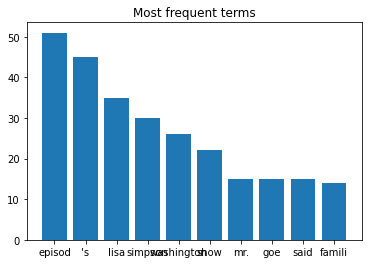

In [167]:
def testTokenzination():
    index = InvertedIndex() # initilaise the index
    corpus = index.read_data('/content/drive/MyDrive/Colab Notebooks/Simpsons2022') # specify the directory path in which files are located
    text = (corpus[0]).string
    start_time = time.perf_counter()
    tokenized = index.process_document(text)
    print("Time taken", time.perf_counter()-start_time)
    counter = Counter(tokenized).most_common(10)
    x = [x for x, _ in counter]
    print(x)
    y = [y for _, y in counter]
    plt.title("Most frequent terms")
    plt.bar(x,y)
testTokenzination()

In [169]:
def main():
    "main call function"
    index = InvertedIndex() # initilaise the index
    corpus = index.read_data('/content/drive/MyDrive/Colab Notebooks/Simpsons2022') # specify the directory path in which files are located
    index.index_corpus(corpus) # index documents/corpus
    return index
index = main()

First 10 entries of csv_terms: {2: {'factori worker', 'yuppi leprechaun', 'tattoo anni', 'rural farm', 'shoot rang', 'dark castl', 'mailman 3', 'eight club', 'last teenag', 'panelist 1', 'hank jockey', 'convent floor', 'virgil simpson', 'sao paulo', 'govern lab', '4yearold lisa', 'district attorney', 'wiener water', 'shore lake', 'beauti salon', 'wild turkey', 'mr. gammil', 'motiv man', 'chariti shelter', '2nd execut', 'insid stadium', 'burlesqu hou', 'larg frog', 'girl kitchen', 'indig woman', 'rich neighborhood', 'dr. carlock', 'giant wall', 'spellymp villag', 'littl girl', 'basement room', 'imax narrat', 'count fudgeula', 'wacki dog', 'terri gross', 'sophist 1', 'andi william', 'farmer billi', 'jitteri privat', 'monorail engin', 'homeless man', 'old folk', 'mike scioscia', 'nasti j', 'alien crier', 'drive cour', 'church yard', 'lifeway editor', 'base tower', 'tea hou', 'view area', 'guidopoli mookemart', 'petroleu rex', 'electroshock room', 'food icon', 'river styx', 'homer jr', 're

100%|██████████| 136796/136796 [00:00<00:00, 249609.88it/s]


It took: 10.1484 seconds to index the whole corpus.
It has 11421 entries in total.


## Test `dump` method using `.txt` provided on BlackBoard

In [170]:
index.dump("/content/drive/MyDrive/Colab Notebooks/26957722.txt")

After initial processing: Bart -> bart; bart 1259 total occurances: ['17 in 3.1.txt: [142, 317, 348, 398, 421, 426, 440, 454, 604, 614, 885, 888, 1117, 1139, 1248, 1798, 1832]', '4 in 3.10.txt: [974, 1149, 1282, 1366]', '4 in 3.11.txt: [446, 641, 740, 768]', '13 in 3.12.txt: [100, 141, 148, 214, 245, 252, 299, 304, 516, 519, 538, 594, 694]', '30 in 3.13.txt: [1, 7, 71, 91, 115, 126, 159, 214, 218, 228, 255, 303, 316, 322, 334, 340, 364, 377, 393, 640, 720, 743, 805, 841, 917, 921, 957, 974, 1143, 1154]', '3 in 3.14.txt: [75, 393, 413]', '10 in 3.15.txt: [69, 115, 144, 306, 331, 422, 558, 583, 596, 741]', '29 in 3.16.txt: [0, 5, 66, 87, 100, 135, 167, 235, 248, 260, 291, 312, 328, 341, 352, 361, 409, 491, 503, 511, 619, 640, 703, 725, 815, 916, 973, 993, 1055]', '2 in 3.17.txt: [91, 1038]', '25 in 3.18.txt: [33, 48, 119, 152, 238, 259, 268, 300, 304, 317, 392, 401, 443, 483, 516, 631, 658, 689, 709, 848, 880, 955, 981, 992, 1008]', '9 in 3.19.txt: [148, 257, 281, 368, 386, 397, 805, 822

## Testing spell-correct

In [171]:
index.dump("/content/drive/MyDrive/Colab Notebooks/typos.txt")

After initial processing: brat -> brat; rat 2 total occurances: ['1 in 3.4.txt: [274]', '1 in 5.20.txt: [496]']
After initial processing: sipmsons -> sipmson; simpson 1657 total occurances: ['31 in 3.1.txt: [9, 66, 98, 114, 261, 393, 500, 785, 944, 1034, 1049, 1082, 1090, 1107, 1128, 1131, 1233, 1239, 1314, 1442, 1458, 1500, 1532, 1551, 1640, 1648, 1671, 1687, 1721, 1818, 1847]', '19 in 3.10.txt: [9, 15, 82, 98, 263, 741, 1073, 1082, 1173, 1226, 1238, 1254, 1316, 1350, 1387, 1410, 1416, 1426, 1437]', '16 in 3.11.txt: [11, 91, 121, 240, 337, 600, 688, 713, 726, 912, 913, 919, 954, 981, 1025, 1067]', '9 in 3.12.txt: [7, 101, 116, 163, 210, 566, 939, 963, 1057]', '14 in 3.13.txt: [8, 65, 80, 317, 512, 865, 871, 893, 949, 978, 988, 994, 1004, 1043]', '6 in 3.14.txt: [8, 79, 94, 135, 918, 960]', '7 in 3.15.txt: [10, 71, 86, 530, 655, 701, 725]', '11 in 3.16.txt: [7, 61, 76, 886, 907, 919, 950, 1026, 1080, 1130, 1150]', '17 in 3.17.txt: [8, 96, 111, 1070, 1097, 1156, 1173, 1241, 1247, 1264, 

## Test positional indexing

In [172]:
index.proximity_search('award', 'winning')

After initial processing: award -> award; After initial processing: winning -> win; Appended! abs(480 - 482)= 2
Appended! abs(497 - 499)= 2
Appended! abs(861 - 862)= 1
Appended! abs(870 - 871)= 1
Appended! abs(331 - 329)= 2
Appended! abs(432 - 434)= 2
Appended! abs(443 - 442)= 1
Appended! abs(140 - 141)= 1
Appended! abs(1101 - 1102)= 1
Appended! abs(1671 - 1672)= 1


{'3.21.txt': [(482, 480), (499, 497)],
 '3.6.txt': [(862, 861), (871, 870)],
 '4.19.txt': [(329, 331)],
 '5.1.txt': [(434, 432)],
 '5.9.txt': [(442, 443)],
 '6.19.txt': [(141, 140)],
 '6.22.txt': [(1102, 1101)],
 '7.6.txt': [(1672, 1671)]}